# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter

warnings.filterwarnings('ignore')

%matplotlib inline

In [93]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [3]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

dPb_BB1 = Pb_data['BB1'][np.isfinite(Pb_data['BB1'])].astype('float')
dPb_BB2 = Pb_data['BB2'][np.isfinite(Pb_data['BB2'])].astype('float')
dPb_BB3 = Pb_data['BB3'][np.isfinite(Pb_data['BB3'])].astype('float')
dPb_CB1 = Pb_data['CB1'][np.isfinite(Pb_data['CB1'])].astype('float')
dPb_CB2 = Pb_data['CB2'][np.isfinite(Pb_data['CB2'])].astype('float')
dPb_CB3 = Pb_data['CB3'][np.isfinite(Pb_data['CB3'])].astype('float')
dPb_CB4 = Pb_data['CB4'][np.isfinite(Pb_data['CB4'])].astype('float')
dPb_CAA1 = Pb_data['CAA1'][np.isfinite(Pb_data['CAA1'])].astype('float')
dPb_CAA2 = Pb_data['CAA2'][np.isfinite(Pb_data['CAA2'])].astype('float')
dPb_CAA3 = Pb_data['CAA3'][np.isfinite(Pb_data['CAA3'])].astype('float')
dPb_CAA4 = Pb_data['CAA4'][np.isfinite(Pb_data['CAA4'])].astype('float')
dPb_CAA5 = Pb_data['CAA5'][np.isfinite(Pb_data['CAA5'])].astype('float')
dPb_CAA6 = Pb_data['CAA6'][np.isfinite(Pb_data['CAA6'])].astype('float')
dPb_CAA7 = Pb_data['CAA7'][np.isfinite(Pb_data['CAA7'])].astype('float')
dPb_CAA8 = Pb_data['CAA8'][np.isfinite(Pb_data['CAA8'])].astype('float')
dPb_CAA9 = Pb_data['CAA9'][np.isfinite(Pb_data['CAA9'])].astype('float')

depth_BB1 = Pb_data['Depth.1'][np.isfinite(Pb_data['BB1'])].astype('float')
depth_BB2 = Pb_data['Depth.2'][np.isfinite(Pb_data['BB2'])].astype('float')
depth_BB3 = Pb_data['Depth.3'][np.isfinite(Pb_data['BB3'])].astype('float')
depth_CB1 = Pb_data['Depth.13'][np.isfinite(Pb_data['CB1'])].astype('float')
depth_CB2 = Pb_data['Depth.14'][np.isfinite(Pb_data['CB2'])].astype('float')
depth_CB3 = Pb_data['Depth.15'][np.isfinite(Pb_data['CB3'])].astype('float')
depth_CB4 = Pb_data['Depth.16'][np.isfinite(Pb_data['CB4'])].astype('float')
depth_CAA1 = Pb_data['Depth.4'][np.isfinite(Pb_data['CAA1'])].astype('float')
depth_CAA2 = Pb_data['Depth.5'][np.isfinite(Pb_data['CAA2'])].astype('float')
depth_CAA3 = Pb_data['Depth.6'][np.isfinite(Pb_data['CAA3'])].astype('float')
depth_CAA4 = Pb_data['Depth.7'][np.isfinite(Pb_data['CAA4'])].astype('float')
depth_CAA5 = Pb_data['Depth.8'][np.isfinite(Pb_data['CAA5'])].astype('float')
depth_CAA6 = Pb_data['Depth.9'][np.isfinite(Pb_data['CAA6'])].astype('float')
depth_CAA7 = Pb_data['Depth.10'][np.isfinite(Pb_data['CAA7'])].astype('float')
depth_CAA8 = Pb_data['Depth.11'][np.isfinite(Pb_data['CAA8'])].astype('float')
depth_CAA9 = Pb_data['Depth.12'][np.isfinite(Pb_data['CAA9'])].astype('float')

In [4]:
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [5]:
# Combine all observations into single collapsed arrays:

obs_depths = np.concatenate((depth_BB1, depth_BB2, depth_BB3, depth_CAA1, depth_CAA2, depth_CAA3, depth_CAA4, \
                             depth_CAA5, depth_CAA6, depth_CAA7, depth_CAA8, depth_CAA9, depth_CB1, depth_CB2, \
                             depth_CB3, depth_CB4))

obs_lons = np.concatenate((np.ones(depth_BB1.shape)*lons[stn_names=='BB1'], \
                          np.ones(depth_BB2.shape)*lons[stn_names=='BB2'], \
                          np.ones(depth_BB3.shape)*lons[stn_names=='BB3'], \
                          np.ones(depth_CAA1.shape)*lons[stn_names=='CAA1'], \
                          np.ones(depth_CAA2.shape)*lons[stn_names=='CAA2'], \
                          np.ones(depth_CAA3.shape)*lons[stn_names=='CAA3'], \
                          np.ones(depth_CAA4.shape)*lons[stn_names=='CAA4'], \
                          np.ones(depth_CAA5.shape)*lons[stn_names=='CAA5'], \
                          np.ones(depth_CAA6.shape)*lons[stn_names=='CAA6'], \
                          np.ones(depth_CAA7.shape)*lons[stn_names=='CAA7'], \
                          np.ones(depth_CAA8.shape)*lons[stn_names=='CAA8'], \
                          np.ones(depth_CAA9.shape)*lons[stn_names=='CAA9'], \
                          np.ones(depth_CB1.shape)*lons[stn_names=='CB1'], \
                          np.ones(depth_CB2.shape)*lons[stn_names=='CB2'], \
                          np.ones(depth_CB3.shape)*lons[stn_names=='CB3'], \
                          np.ones(depth_CB4.shape)*lons[stn_names=='CB4']))

obs_lats = np.concatenate((np.ones(depth_BB1.shape)*lats[stn_names=='BB1'], \
                          np.ones(depth_BB2.shape)*lats[stn_names=='BB2'], \
                          np.ones(depth_BB3.shape)*lats[stn_names=='BB3'], \
                          np.ones(depth_CAA1.shape)*lats[stn_names=='CAA1'], \
                          np.ones(depth_CAA2.shape)*lats[stn_names=='CAA2'], \
                          np.ones(depth_CAA3.shape)*lats[stn_names=='CAA3'], \
                          np.ones(depth_CAA4.shape)*lats[stn_names=='CAA4'], \
                          np.ones(depth_CAA5.shape)*lats[stn_names=='CAA5'], \
                          np.ones(depth_CAA6.shape)*lats[stn_names=='CAA6'], \
                          np.ones(depth_CAA7.shape)*lats[stn_names=='CAA7'], \
                          np.ones(depth_CAA8.shape)*lats[stn_names=='CAA8'], \
                          np.ones(depth_CAA9.shape)*lats[stn_names=='CAA9'], \
                          np.ones(depth_CB1.shape)*lats[stn_names=='CB1'], \
                          np.ones(depth_CB2.shape)*lats[stn_names=='CB2'], \
                          np.ones(depth_CB3.shape)*lats[stn_names=='CB3'], \
                          np.ones(depth_CB4.shape)*lats[stn_names=='CB4']))

obs_dPb = np.concatenate((dPb_BB1, dPb_BB2, dPb_BB3, dPb_CAA1, dPb_CAA2, dPb_CAA3, dPb_CAA4, \
                         dPb_CAA5, dPb_CAA6, dPb_CAA7, dPb_CAA8, dPb_CAA9, dPb_CB1, dPb_CB2, \
                         dPb_CB3, dPb_CB4))

#### Functions

In [6]:
def assoc_depth(depth_obs):
    
    # find depths that are in common
    common_depths = np.empty_like(depth_obs)
    index_depths  = np.empty_like(depth_obs)
    
    i=0
    for depth in depth_obs:
        min_val  = np.argmin(np.abs(POC_dep - depth))
        if np.abs(POC_dep[min_val] - depth) > 100:
            common_depths[i] = np.nan
            index_depths[i]  = np.nan
        else:
            common_depths[i] = POC_dep[min_val]
            index_depths[i]  = min_val
        i+=1
        
    return common_depths, index_depths

### Dissolved Pb vs. POC flux

In [30]:
POC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/b.e11.B1850C5CN.f09_g16.005.pop.h.POC_FLUX_IN.200001-209912.nc')
POC_lon  = np.array(POC.variables['TLONG'])
POC_lat  = np.array(POC.variables['TLAT'])
POC_dep  = np.array(POC.variables['z_t'])*1e-2    # depth from surface (cm)
POC_time = np.array(POC.variables['time'])        # days since 0000-01-01 00:00:00, noleap
POC_flux = np.array(POC.variables['POC_FLUX_IN']) # mmol /m3 cm/s

In [31]:
POC_date = [dt.datetime(1,1,1) + dt.timedelta(days=t) for t in POC_time]

print('Most similar date to collection of observations:', POC_date[191])

Most similar date to collection of observations: 2015-08-31 00:00:00


In [32]:
# Find corresponding lons at lats for POC flux compared to the station locations:

i_stn = []
j_stn = []
for stn in range(0,len(obs_lons)):
    i, j = ar.find_closest_model_point(360+obs_lons[stn], obs_lats[stn], POC_lon, POC_lat, \
                                       tols={'NEMO': {'tol_lon': 0.5, 'tol_lat': 0.5}})
    i_stn.append(i)
    j_stn.append(j)
    
i_POC = np.array(i_stn)
j_POC = np.array(j_stn)

In [33]:
POC_common_depths, POC_z_index = assoc_depth(obs_depths)

In [34]:
POC_array = []

for ind in range(0,len(obs_depths)):
    try:
#         print(POC_z_index[ind], i_POC[ind], j_POC[ind])
        POC_flx = POC_flux[191, int(POC_z_index[ind]), i_POC[ind], j_POC[ind]]
    except:
        POC_flx = np.nan
        
    POC_array.append(POC_flx)
    
POC_flux_stns = np.array(POC_array)

POC_flux_stns[POC_flux_stns > 1e10] = np.nan
POC_flux_stns[POC_flux_stns == 0.0] = np.nan

In [35]:
# Mask places where depths are too different:

dPb_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_dPb)), obs_dPb)
POC_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_dPb)), POC_flux_stns)

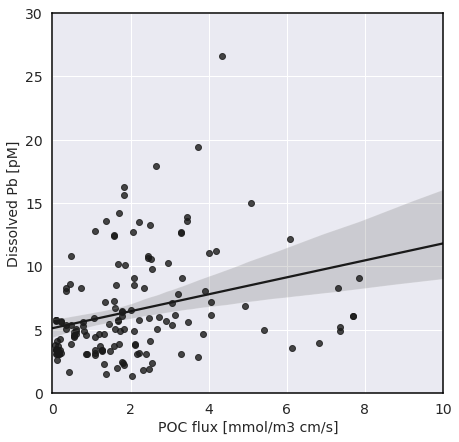

In [37]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
    ax.set(ylim=(0,30.0), xlim=(0,10.0))
    sns.regplot(POC_masked*1e5, dPb_masked*1e3, truncate=False, ax=ax, color='k')
#     ax = sns.scatterplot(POC_masked*1e5, dPb_masked*1e3, color='k', s=100)
    
    ax.set_ylabel('Dissolved Pb [pM]', fontsize=14)
    ax.set_xlabel('POC flux [mmol/m3 cm/s]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

POC drop metric:

In [129]:
drop_BB1 = np.nanmean(dPb_BB1[depth_BB1 < 100]) - dPb_BB1[depth_BB1 > 100]; 
drop_BB2 = np.nanmean(dPb_BB2[depth_BB2 < 100]) - dPb_BB2[depth_BB2 > 100]; 
drop_BB3 = np.nanmean(dPb_BB3[depth_BB3 < 100]) - dPb_BB3[depth_BB3 > 100]; 
ddep_BB1 = depth_BB1[depth_BB1 > 100]; ddep_BB2 = depth_BB2[depth_BB2 > 100]; 
ddep_BB3 = depth_BB3[depth_BB3 > 100];

drop_CB1 = np.nanmean(dPb_CB1[depth_CB1 < 100]) - dPb_CB1[depth_CB1 > 100];
drop_CB2 = np.nanmean(dPb_CB2[depth_CB2 < 100]) - dPb_CB2[depth_CB2 > 100];
drop_CB3 = np.nanmean(dPb_CB3[depth_CB3 < 100]) - dPb_CB3[depth_CB3 > 100];
drop_CB4 = np.nanmean(dPb_CB4[depth_CB4 < 100]) - dPb_CB4[depth_CB4 > 100];
ddep_CB1 = depth_CB1[depth_CB1 > 100]; ddep_CB2 = depth_CB2[depth_CB2 > 100];
ddep_CB3 = depth_CB3[depth_CB3 > 100]; ddep_CB4 = depth_CB4[depth_CB4 > 100];

drop_CAA1 = np.nanmean(dPb_CAA1[depth_CAA1 < 100]) - dPb_CAA1[depth_CAA1 > 100];
drop_CAA2 = np.nanmean(dPb_CAA2[depth_CAA2 < 100]) - dPb_CAA2[depth_CAA2 > 100];
drop_CAA3 = np.nanmean(dPb_CAA3[depth_CAA3 < 100]) - dPb_CAA3[depth_CAA3 > 100];
drop_CAA4 = np.nanmean(dPb_CAA4[depth_CAA4 < 100]) - dPb_CAA4[depth_CAA4 > 100];
drop_CAA5 = np.nanmean(dPb_CAA5[depth_CAA5 < 100]) - dPb_CAA5[depth_CAA5 > 100];
drop_CAA6 = np.nanmean(dPb_CAA6[depth_CAA6 < 100]) - dPb_CAA6[depth_CAA6 > 100];
drop_CAA7 = np.nanmean(dPb_CAA7[depth_CAA7 < 100]) - dPb_CAA7[depth_CAA7 > 100];
drop_CAA8 = np.nanmean(dPb_CAA8[depth_CAA8 < 100]) - dPb_CAA8[depth_CAA8 > 100];
drop_CAA9 = np.nanmean(dPb_CAA9[depth_CAA9 < 100]) - dPb_CAA9[depth_CAA9 > 100];
ddep_CAA1 = depth_CAA1[depth_CAA1 > 100]; ddep_CAA2 = depth_CAA2[depth_CAA2 > 100];
ddep_CAA3 = depth_CAA3[depth_CAA3 > 100]; ddep_CAA4 = depth_CAA4[depth_CAA4 > 100];
ddep_CAA5 = depth_CAA5[depth_CAA5 > 100]; ddep_CAA6 = depth_CAA6[depth_CAA6 > 100];
ddep_CAA7 = depth_CAA7[depth_CAA7 > 100]; ddep_CAA8 = depth_CAA8[depth_CAA8 > 100];
ddep_CAA9 = depth_CAA9[depth_CAA9 > 100];

drop_Pb = np.concatenate((drop_BB1, drop_BB2, drop_BB3, drop_CAA1, drop_CAA2, drop_CAA3, drop_CAA4, \
                      drop_CAA5, drop_CAA6, drop_CAA7, drop_CAA8, drop_CAA9, drop_CB1, drop_CB2, \
                      drop_CB3, drop_CB4))

drop_depth = np.concatenate((depth_BB1[depth_BB1 > 100], depth_BB2[depth_BB2 > 100], depth_BB3[depth_BB3 > 100], \
                              depth_CAA1[depth_CAA1 > 100], depth_CAA2[depth_CAA2 > 100], depth_CAA3[depth_CAA3 > 100], \
                              depth_CAA4[depth_CAA4 > 100], depth_CAA5[depth_CAA5 > 100], depth_CAA6[depth_CAA6 > 100], \
                              depth_CAA7[depth_CAA7 > 100], depth_CAA8[depth_CAA8 > 100], depth_CAA9[depth_CAA9 > 100], \
                              depth_CB1[depth_CB1 > 100], depth_CB2[depth_CB2 > 100], depth_CB3[depth_CB3 > 100], \
                              depth_CB4[depth_CB4 > 100]))

In [132]:
drop_lons = np.concatenate((np.ones(depth_BB1[depth_BB1 > 100].shape)*lons[stn_names=='BB1'], \
                          np.ones(depth_BB2[depth_BB2 > 100].shape)*lons[stn_names=='BB2'], \
                          np.ones(depth_BB3[depth_BB3 > 100].shape)*lons[stn_names=='BB3'], \
                          np.ones(depth_CAA1[depth_CAA1 > 100].shape)*lons[stn_names=='CAA1'], \
                          np.ones(depth_CAA2[depth_CAA2 > 100].shape)*lons[stn_names=='CAA2'], \
                          np.ones(depth_CAA3[depth_CAA3 > 100].shape)*lons[stn_names=='CAA3'], \
                          np.ones(depth_CAA4[depth_CAA4 > 100].shape)*lons[stn_names=='CAA4'], \
                          np.ones(depth_CAA5[depth_CAA5 > 100].shape)*lons[stn_names=='CAA5'], \
                          np.ones(depth_CAA6[depth_CAA6 > 100].shape)*lons[stn_names=='CAA6'], \
                          np.ones(depth_CAA7[depth_CAA7 > 100].shape)*lons[stn_names=='CAA7'], \
                          np.ones(depth_CAA8[depth_CAA8 > 100].shape)*lons[stn_names=='CAA8'], \
                          np.ones(depth_CAA9[depth_CAA9 > 100].shape)*lons[stn_names=='CAA9'], \
                          np.ones(depth_CB1[depth_CB1 > 100].shape)*lons[stn_names=='CB1'], \
                          np.ones(depth_CB2[depth_CB2 > 100].shape)*lons[stn_names=='CB2'], \
                          np.ones(depth_CB3[depth_CB3 > 100].shape)*lons[stn_names=='CB3'], \
                          np.ones(depth_CB4[depth_CB4 > 100].shape)*lons[stn_names=='CB4']))

drop_lats = np.concatenate((np.ones(depth_BB1[depth_BB1 > 100].shape)*lats[stn_names=='BB1'], \
                          np.ones(depth_BB2[depth_BB2 > 100].shape)*lats[stn_names=='BB2'], \
                          np.ones(depth_BB3[depth_BB3 > 100].shape)*lats[stn_names=='BB3'], \
                          np.ones(depth_CAA1[depth_CAA1 > 100].shape)*lats[stn_names=='CAA1'], \
                          np.ones(depth_CAA2[depth_CAA2 > 100].shape)*lats[stn_names=='CAA2'], \
                          np.ones(depth_CAA3[depth_CAA3 > 100].shape)*lats[stn_names=='CAA3'], \
                          np.ones(depth_CAA4[depth_CAA4 > 100].shape)*lats[stn_names=='CAA4'], \
                          np.ones(depth_CAA5[depth_CAA5 > 100].shape)*lats[stn_names=='CAA5'], \
                          np.ones(depth_CAA6[depth_CAA6 > 100].shape)*lats[stn_names=='CAA6'], \
                          np.ones(depth_CAA7[depth_CAA7 > 100].shape)*lats[stn_names=='CAA7'], \
                          np.ones(depth_CAA8[depth_CAA8 > 100].shape)*lats[stn_names=='CAA8'], \
                          np.ones(depth_CAA9[depth_CAA9 > 100].shape)*lats[stn_names=='CAA9'], \
                          np.ones(depth_CB1[depth_CB1 > 100].shape)*lats[stn_names=='CB1'], \
                          np.ones(depth_CB2[depth_CB2 > 100].shape)*lats[stn_names=='CB2'], \
                          np.ones(depth_CB3[depth_CB3 > 100].shape)*lats[stn_names=='CB3'], \
                          np.ones(depth_CB4[depth_CB4 > 100].shape)*lats[stn_names=='CB4']))

In [133]:
# Find corresponding lons at lats for POC flux compared to the station locations:

i_stn_drop = []; j_stn_drop = [];
for stn in range(0,len(drop_lons)):
    i, j = ar.find_closest_model_point(360+drop_lons[stn], drop_lats[stn], POC_lon, POC_lat, \
                                       tols={'NEMO': {'tol_lon': 0.5, 'tol_lat': 0.5}})
    i_stn_drop.append(i)
    j_stn_drop.append(j)
    
i_POC_drop = np.array(i_stn_drop)
j_POC_drop = np.array(j_stn_drop)

In [134]:
POC_drop_depths, POC_drop_z_index = assoc_depth(drop_depth)

In [135]:
POC_array_drop = []

for ind in range(0,len(drop_depth)):
    try:
#         print(POC_z_index[ind], i_POC[ind], j_POC[ind])
        POC_flx = POC_flux[191, int(POC_drop_z_index[ind]), i_POC_drop[ind], j_POC_drop[ind]]
    except:
        POC_flx = np.nan
        
    POC_array_drop.append(POC_flx)
    
POC_flux_stns_drop = np.array(POC_array_drop)

POC_flux_stns_drop[POC_flux_stns_drop > 1e10] = np.nan
POC_flux_stns_drop[POC_flux_stns_drop == 0.0] = np.nan

In [136]:
# Mask places where depths are too different:

dPb_drop_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns_drop), np.isnan(drop_Pb)), drop_Pb)
POC_drop_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns_drop), np.isnan(drop_Pb)), POC_flux_stns_drop)

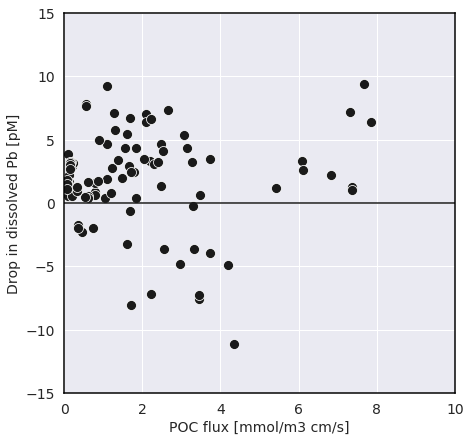

In [138]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, c='k')
    sns.scatterplot(POC_drop_masked*1e5, dPb_drop_masked*1e3, color='k', s=100)
    sns.lineplot([0, 100], [0, 0], c='k')
    
    ax.set_ylabel('Drop in dissolved Pb [pM]', fontsize=14)
    ax.set_xlabel('POC flux [mmol/m3 cm/s]', fontsize=14)
    ax.set(ylim=(-15,15), xlim=(0,10.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

### Attempts that failed:

POC flux versus dissolved Pb decrease. Where POC flux is high, I expect dissolved Pb to be removed rapidly, so to decrease strongly with depth.

In [94]:
def calc_deriv(dPb, depth, visualize=False):
    
    dPb   = np.array(dPb)
    depth = np.array(depth)
    
    # smooth the array:
    dPb_smooth = savgol_filter(dPb, 9, 3)

    if visualize:
        fig, ax = plt.subplots(1,1,figsize=(4,6))
        ax.invert_yaxis()
        ax.scatter(dPb, depth, label='original')
        ax.scatter(dPb_smooth, depth, label='smoothed')
        ax.legend()
    
    # calculate the derivative:    
    deriv = [(dPb_smooth[i+1] - dPb_smooth[i])/(depth[i+1] - depth[i]) for i in range(0,len(dPb)-1)]
    
    # add NaN as the last element so that the array length is equal to the rest
    deriv.append(np.nan) 
    
    return np.array(deriv)

In [95]:
# Calculate Pb drop with depth:
d_BB1 = calc_deriv(dPb_BB1, depth_BB1); d_BB2 = calc_deriv(dPb_BB2, depth_BB2); 
d_BB3 = calc_deriv(dPb_BB3, depth_BB3); d_CB1 = calc_deriv(dPb_CB1, depth_CB1);
d_CB2 = calc_deriv(dPb_CB2, depth_CB2); d_CB3 = calc_deriv(dPb_CB3, depth_CB3);
d_CB4 = calc_deriv(dPb_CB4, depth_CB4); d_CAA1 = calc_deriv(dPb_CAA1, depth_CAA1);
d_CAA2 = calc_deriv(dPb_CAA2, depth_CAA2); d_CAA3 = calc_deriv(dPb_CAA3, depth_CAA3);
d_CAA4 = calc_deriv(dPb_CAA4, depth_CAA4); d_CAA5 = calc_deriv(dPb_CAA5, depth_CAA5);
d_CAA6 = calc_deriv(dPb_CAA6, depth_CAA6); d_CAA7 = calc_deriv(dPb_CAA7, depth_CAA7);
d_CAA8 = calc_deriv(dPb_CAA8, depth_CAA8); d_CAA9 = calc_deriv(dPb_CAA9, depth_CAA9);

# Combine all observations into single collapsed arrays:
obs_d_dPb = np.concatenate((d_BB1, d_BB2, d_BB3, d_CAA1, d_CAA2, d_CAA3, d_CAA4, \
                            d_CAA5, d_CAA6, d_CAA7, d_CAA8, d_CAA9, d_CB1, d_CB2, \
                            d_CB3, d_CB4))

obs_d_dPb[np.isinf(np.abs(obs_d_dPb))] = np.nan

In [96]:
# Mask places where depths are too different:
d_dPb_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_d_dPb)), obs_d_dPb)
POC_masked   = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_d_dPb)), POC_flux_stns)

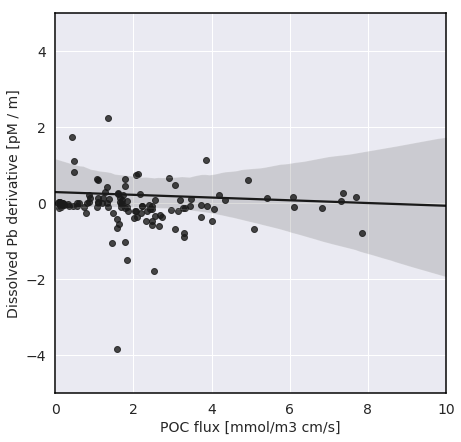

In [100]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
    ax.set(ylim=(-5,5), xlim=(0,10.0))
    sns.regplot(POC_masked*1e5, d_dPb_masked*1e4, truncate=False, ax=ax, color='k')
#     ax = sns.scatterplot(POC_masked*1e5, dPb_masked*1e3, color='k', s=100)
    
    ax.set_ylabel('Dissolved Pb derivative [pM / m]', fontsize=14)
    ax.set_xlabel('POC flux [mmol/m3 cm/s]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    